In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/gl_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/gl_to_en/1.0.0.incomplete6XYDTN/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/gl_to_en/1.0.0.incomplete6XYDTN/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/gl_to_en/1.0.0.incomplete6XYDTN/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/gl_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for ru, en in train_examples), target_vocab_size=2**13)

tokenizer_ru = tfds.features.text.SubwordTextEncoder.build_from_corpus((ru.numpy() for ru, en in train_examples), target_vocab_size=2**13)

In [4]:
sample_str = 'Data Science is awesome.'

token_str = tokenizer_en.encode(sample_str)
print ('Tokenized string is {}'.format(token_str))

original_str = tokenizer_en.decode(token_str)
print ('The original string: {}'.format(original_str))


Tokenized string is [7846, 1444, 7, 7861, 7440, 115, 12, 7596, 7824]
The original string: Data Science is awesome.


In [0]:
BUFFER_SIZE=20000
BATCH_SIZE=64

In [0]:
def encode(lang1, lang2):
  lang1 = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(lang1.numpy()) + [tokenizer_ru.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [0]:
def tfEncode(ru, en):
  result_ru, result_en = tf.py_function(encode, [ru, en], [tf.int64, tf.int64])
  result_ru.set_shape([None])
  result_en.set_shape([None])

  return result_ru, result_en

In [0]:
MAX_LENGTH = 40

In [0]:
def filterMxLen(x, y, max_len=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_len,tf.size(y) <= max_len)

In [10]:
trainDs = train_examples.map(tfEncode)
trainDs = trainDs.filter(filterMxLen)

trainDs = trainDs.cache()
trainDs = trainDs.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
trainDs = trainDs.prefetch(tf.data.experimental.AUTOTUNE)


valDs = val_examples.map(tfEncode)
valDs = valDs.filter(filterMxLen).padded_batch(BATCH_SIZE)

ru_batch, en_batch = next(iter(valDs))
ru_batch, en_batch

(<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[7796,  167, 3548, ...,    0,    0,    0],
        [7796,   39, 6382, ...,    0,    0,    0],
        [7796,   45,    5, ...,    0,    0,    0],
        ...,
        [7796, 2253,    6, ...,    0,    0,    0],
        [7796,    8,  119, ...,    0,    0,    0],
        [7796,  117,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 37), dtype=int64, numpy=
 array([[8034,    3, 4431, ...,    0,    0,    0],
        [8034,   33,   13, ...,    0,    0,    0],
        [8034,    3, 1049, ...,    0,    0,    0],
        ...,
        [8034,   18,    8, ...,    0,    0,    0],
        [8034,   18,    8, ...,    0,    0,    0],
        [8034,  154,   21, ...,    0,    0,    0]])>)

In [0]:
#Positional Encoding

def getAngles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


In [0]:
def posEncoding(pos, d_model):
  angle_rads = getAngles(np.arange(pos)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 60, 512)


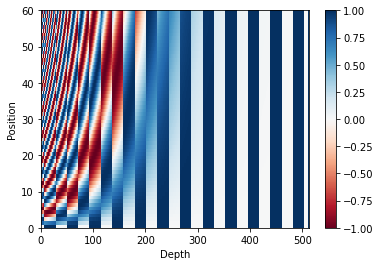

In [13]:
pos_encoding = posEncoding(60, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
#Masking

def createPadMask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]

In [0]:
def createLAMask(size): #Mask for lookahead
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [0]:
#Scaled Dot Product Attention

def SDPAttention(q, k, v, mask):
  qk = tf.matmul(q, k, transpose_b=True)

  #Scaling the QK matrix  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  #Preparing argument of Softmax
  SALogits = qk / tf.math.sqrt(dk)
  
  if mask is not None:
    SALogits += (mask * -1e9)  

  #Making the scores add up to 1.
  weights = tf.nn.softmax(SALogits, axis=-1)  
  output = tf.matmul(weights, v) 

  return output, weights

In [0]:
def printOut(q, k, v):
  temp_out, temp_attn = SDPAttention(q, k, v, None)
  print ('Attention weights:')
  print (temp_attn)
  print ('Output:')
  print (temp_out)

In [0]:
#Multi-Head Attention Mechanism

class MHAttn(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    self.depth = d_model // self.num_heads
    
    self.Wq = tf.keras.layers.Dense(d_model)
    self.Wk = tf.keras.layers.Dense(d_model)
    self.Wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def splitHeads(self, x, batch_size):
    #Splitting into multiple attention heads so that it can gather information from different positions efficiently
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3]) #concatenating the attention output of each head
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    #obtaining the required input vectors for the model
    q = self.Wq(q)
    k = self.Wk(k)  
    v = self.Wv(v)  
    
    q = self.splitHeads(q, batch_size)  
    k = self.splitHeads(k, batch_size)  
    v = self.splitHeads(v, batch_size)
    
    attn, attnWeights = SDPAttention(q, k, v, mask)
    
    attn = tf.transpose(attn, perm=[0, 2, 1, 3]) 

    concat_attention = tf.reshape(attn, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)
        
    return output, attnWeights

In [0]:
#Position Wise Feed Forward Network
def FFNetwork(d_model, dff):#dff is the dimensionality of the output space
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'),tf.keras.layers.Dense(d_model)])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.mha = MHAttn(d_model, num_heads)
    self.ffn = FFNetwork(d_model, dff)

    self.lnorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, train, mask):
    #Output of each sublayer is LayerNorm(x + Sublayer(x))
    
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=train)
    out1 = self.lnorm1(x + attn_output)
    
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=train)
    out2 = self.lnorm2(out1 + ffn_output) 
    
    return out2

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.mha1 = MHAttn(d_model, num_heads)
    self.mha2 = MHAttn(d_model, num_heads)

    self.ffn = FFNetwork(d_model, dff)
 
    self.lnorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, train, look_ahead_mask, padding_mask):

    attn1, weights1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=train)
    out1 = self.lnorm1(attn1 + x)
    
    attn2, weights2 = self.mha2(enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=train)
    out2 = self.lnorm2(attn2 + out1)
    
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=train)
    out3 = self.lnorm3(ffn_output + out2)
    
    return out3, weights1, weights2

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocabSize, maxPosEncoding, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(vocabSize, d_model)
    self.posEnc = posEncoding(maxPosEncoding, self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, train, mask):

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.posEnc[:, :seq_len, :]

    x = self.dropout(x, training=train)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, train, mask)
    
    return x

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocabSize, maxPosEncoding, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(vocabSize, d_model)
    self.posEnc = posEncoding(maxPosEncoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, encOut, train, LAMask, padMask):

    seq_len = tf.shape(x)[1]
    weights = {}
    
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.posEnc[:, :seq_len, :]
    
    x = self.dropout(x, training=train)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, encOut, train, LAMask, padMask)
      
      weights['decoder_layer{}_block1'.format(i+1)] = block1
      weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    return x, weights

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, vocabSizeInp, vocabSizeTar, pe_input, pe_target, rate=0.1):
    super().__init__()

#max_posEnc_inp==pe_input

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, vocabSizeInp, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, vocabSizeTar, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(vocabSizeTar)
    
  def call(self, inp, tar, train, encPadMask, LAMask, decPadMask):

    enc_output = self.encoder(inp, train, encPadMask)  
    
    
    dec_output, weights = self.decoder(tar, enc_output, train, LAMask, decPadMask)
    
    final_output = self.final_layer(dec_output)  
    
    return final_output, weights



In [0]:
#HyperParameters

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

vocabSizeInp = tokenizer_ru.vocab_size + 2
vocabSizeTar = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [0]:
#Adam Optimizer

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [0]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
#Loss Function
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [0]:
#Creating instance of transformer class for translating Russian to English

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          vocabSizeInp, vocabSizeTar, 
                          pe_input=vocabSizeInp, 
                          pe_target=vocabSizeTar,
                          rate=dropout_rate)

In [0]:
#Creating Masks for Padding and LookAhead

def create_masks(inp, tar):
  # Encoder padding mask
  encPadMask = createPadMask(inp)
  
# Decoder padding mask
  decPadMask = createPadMask(inp)
  
  # Decoder mask for future tokens 
  LAMask = createLAMask(tf.shape(tar)[1])
  dec_target_padding_mask = createPadMask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask,  LAMask)
  
  return  encPadMask, combined_mask,  decPadMask

In [0]:
#CheckPointing

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [34]:
print(trainDs)

<DatasetV1Adapter shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


In [0]:
EPOCHS = 30

In [0]:
# The @tf.function is used to improve the efficiency. 


train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  encPadMask, combined_mask, decPadMask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 encPadMask, 
                                 combined_mask, 
                                 decPadMask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [44]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> russian, tar -> english
  for (batch, (inp, tar)) in enumerate(trainDs):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('IterationNumber {} BatchNumber {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
                                                         
    
  print ('IterationNumber {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
                                                
                                                

  print ('Time taken for 1 Iteration: {} secs\n'.format(time.time() - start))

IterationNumber 1 BatchNumber 0 Loss 7.4495 Accuracy 0.0495
IterationNumber 1 BatchNumber 50 Loss 7.1957 Accuracy 0.0483
IterationNumber 1 BatchNumber 100 Loss 7.0028 Accuracy 0.0491
IterationNumber 1 Loss 6.8951 Accuracy 0.0492
Time taken for 1 Iteration: 187.39168620109558 secs

IterationNumber 2 BatchNumber 0 Loss 6.3783 Accuracy 0.0485
IterationNumber 2 BatchNumber 50 Loss 6.3934 Accuracy 0.0583
IterationNumber 2 BatchNumber 100 Loss 6.3355 Accuracy 0.0645
IterationNumber 2 Loss 6.2814 Accuracy 0.0694
Time taken for 1 Iteration: 190.74274563789368 secs

IterationNumber 3 BatchNumber 0 Loss 5.9769 Accuracy 0.0785
IterationNumber 3 BatchNumber 50 Loss 5.9468 Accuracy 0.0907
IterationNumber 3 BatchNumber 100 Loss 5.8565 Accuracy 0.0924
IterationNumber 3 Loss 5.7996 Accuracy 0.0941
Time taken for 1 Iteration: 188.00623536109924 secs

IterationNumber 4 BatchNumber 0 Loss 5.4471 Accuracy 0.1076
IterationNumber 4 BatchNumber 50 Loss 5.4509 Accuracy 0.1065
IterationNumber 4 BatchNumber 100

In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_ru.vocab_size]
  end_token = [tokenizer_ru.vocab_size + 1]
  
  inp_sentence = start_token + tokenizer_ru.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    encPadMask, combined_mask, decPadMask = create_masks(encoder_input, output)
  
    predictions, weights = transformer(encoder_input, 
                                      output,
                                      False,
                                      encPadMask,
                                      combined_mask,
                                      decPadMask)
    
    predictions = predictions[: ,-1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), weights
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), weights

In [0]:
def AttnWeightsPlt(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ru.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 6}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(['<start>']+[tokenizer_ru.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, weights = evaluate(sentence)
  
  predicted = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Prediction: {}'.format(predicted))
  
  if plot:
    AttnWeightsPlt(weights, sentence, result, plot)

Input: que teñas un bo día
Prediction:  . .


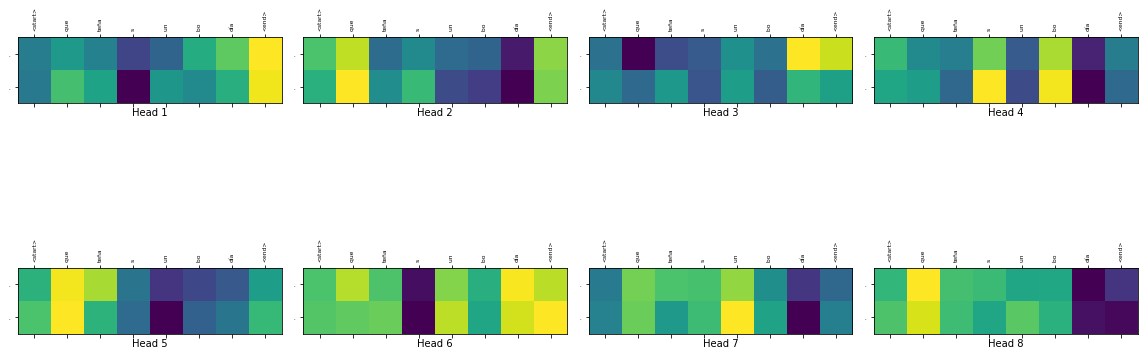

Real: Have a nice day.


In [41]:
translate("que teñas un bo día", plot='decoder_layer4_block2')
print ("Real: Have a nice day.")

Input: como te chamas?
Prediction:  . .


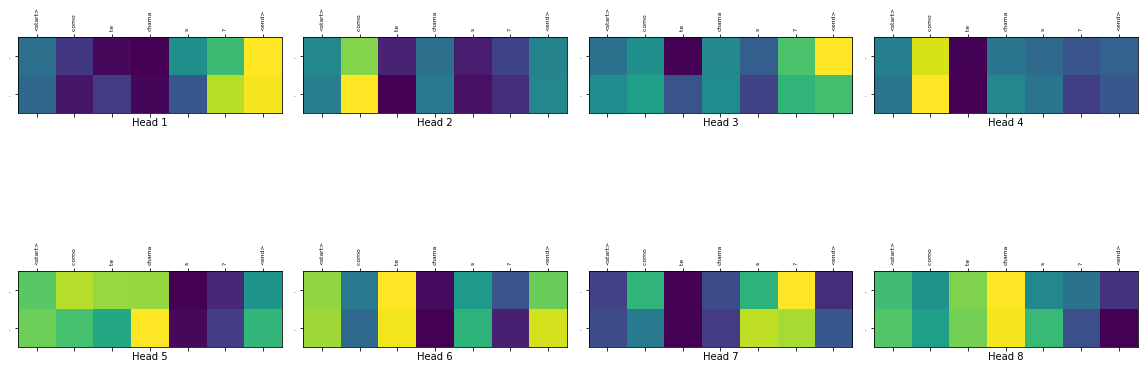

Real: what is your name?


In [42]:

translate("como te chamas?", plot='decoder_layer4_block2')
print ("Real: what is your name?")

Input: gústame xogar ao fútbol
Prediction: i love to play a game in los angeles ground .


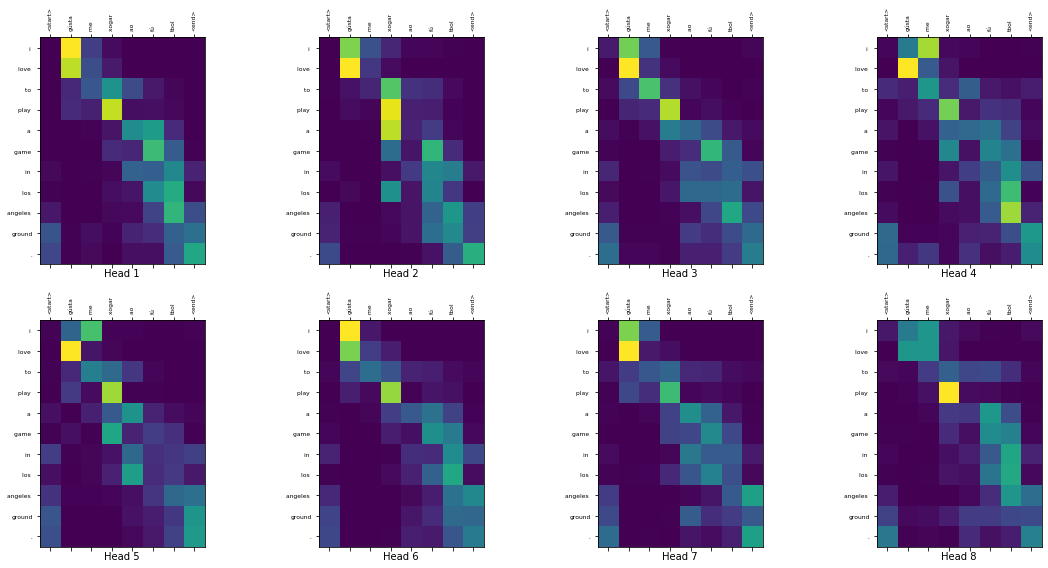

Real: I like to play football


In [50]:
translate("gústame xogar ao fútbol", plot='decoder_layer4_block2')
print ("Real: I like to play football")